<a href="https://colab.research.google.com/github/josefernandezest98/training/blob/main/Change_Point_Detection/change_point_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Change Point Detection

# 1. Ruptures

In [2]:
!pip install ruptures

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.4 MB/s eta 0:00:00


In [3]:
import ruptures as rpt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

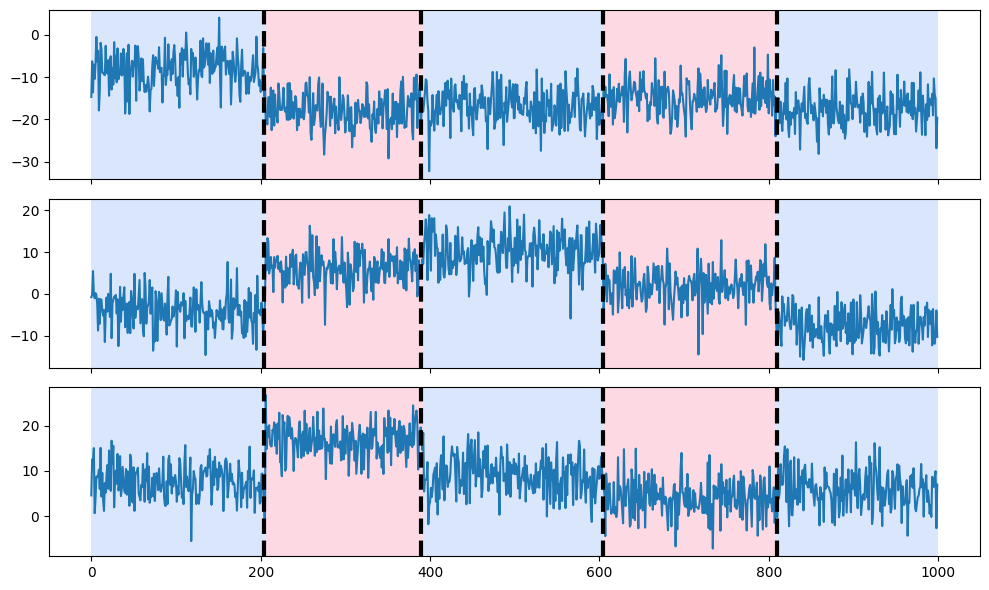

In [4]:
# generate signal
n_samples, dim, sigma = 1000, 3, 4
n_bkps = 4  # number of breakpoints
signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma)

# detection
model = rpt.Pelt(model="rbf")
model.fit(signal)

result = model.predict(pen=10)

# display
rpt.display(signal, bkps, result)
plt.show()

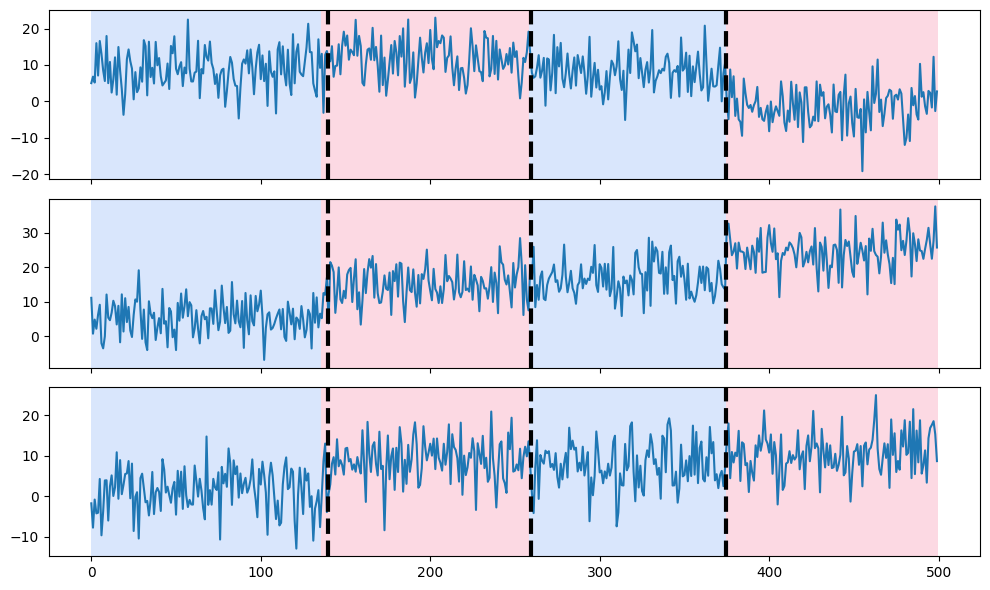

In [5]:
# creation of data
n, dim = 500, 3
n_bkps, sigma = 3, 5
signal, bkps = rpt.pw_constant(n, dim, n_bkps, noise_std=sigma)

# change point detection
model = "l1"  # "l2", "rbf"
algo = rpt.Dynp(model=model, min_size=3, jump=5).fit(signal)
my_bkps = algo.predict(n_bkps=3)

# show results
rpt.show.display(signal, bkps, my_bkps, figsize=(10, 6))
plt.show()

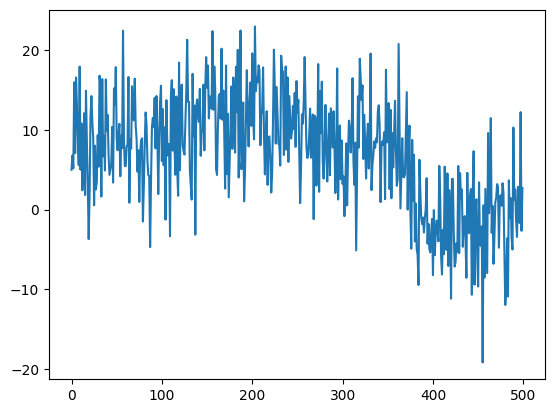

In [6]:
y = [signal[i][0] for i in range(len(signal))]
x = list(range(len(y)))

plt.plot(x,y)

# 2. Piece-wise Linear Regression

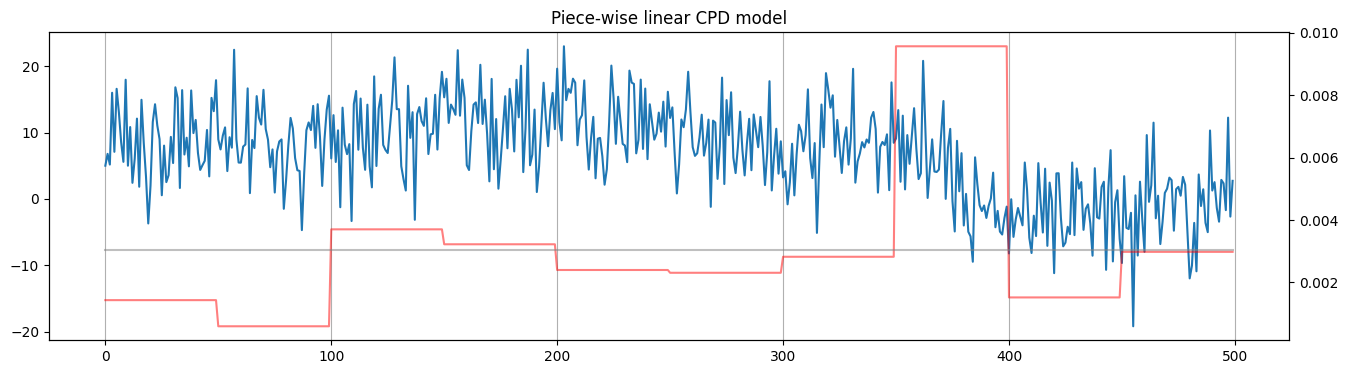

In [7]:
from sklearn.linear_model import LinearRegression

def piece_wise_lr_cpd(data, columnName, piece_diff=100):

  st_idx, end_idx = 0, piece_diff
  coeff = []
  while end_idx<=data.shape[0]:

      X = [[x] for x in np.arange(piece_diff)]
      y = list(data.iloc[list(range(st_idx, end_idx, 1))][columnName])

      min_v, max_v = min(y), max(y)
      y = [(x-min_v)/(max_v-min_v) for x in y]

      model = LinearRegression()
      model.fit(X, y)

      coeff.extend([abs(model.coef_[0])]*piece_diff)
      #print(data.iloc[st_idx].index, data.iloc[end_idx].index, abs(model.coef_[0]))

      st_idx = end_idx
      end_idx = end_idx+piece_diff

  return coeff

# compute results
ts_df = pd.DataFrame()
ts_df['index'] = x
ts_df['series_1'] = y
ts_df['coeff_1'] = piece_wise_lr_cpd(ts_df, 'series_1', piece_diff=50)

# Plot the results
fig, ax1 = plt.subplots(figsize=(16,4))
ax2 = ax1.twinx()
ax1.plot(ts_df.index, ts_df.series_1)
ax2.plot(ts_df.index, ts_df.coeff_1, color='red', alpha=0.5)
ax2.plot(ts_df.index, [np.mean(ts_df.coeff_1)]*ts_df.shape[0], color='grey', alpha=0.5)
ax1.grid(axis='x')
plt.title('Piece-wise linear CPD model')
plt.show()

# 3. Ruptures own library

In [8]:
# dataset creation

### 3.2.1 Costs function least absolute deviation (L1)

In [9]:
class CostL1(BaseCost):
    r"""Least absolute deviation."""

    model = "l1"

    def __init__(self) -> None:
        """Initialize the object."""
        self.signal = None
        self.min_size = 2

    def fit(self, signal) -> "CostL1":
        """Set parameters of the instance.

        Args:
            signal (array): signal. Shape (n_samples,) or (n_samples, n_features)

        Returns:
            self
        """
        if signal.ndim == 1:
            self.signal = signal.reshape(-1, 1)
        else:
            self.signal = signal

        return self

    def error(self, start, end) -> float:
        """Return the approximation cost on the segment [start:end].

        Args:
            start (int): start of the segment
            end (int): end of the segment

        Returns:
            segment cost

        Raises:
            NotEnoughPoints: when the segment is too short (less than `min_size` samples).
        """
        if end - start < self.min_size:
            raise NotEnoughPoints
        sub = self.signal[start:end]
        med = np.median(sub, axis=0)

        return abs(sub - med).sum()

### 3.2.2 Costs function least squared deviation (L2)

In [ ]:
class CostL2(BaseCost):
    r"""Least squared deviation."""

    model = "l2"

    def __init__(self):
        """Initialize the object."""
        self.signal = None
        self.min_size = 1

    def fit(self, signal) -> "CostL2":
        """Set parameters of the instance.

        Args:
            signal (array): array of shape (n_samples,) or (n_samples, n_features)

        Returns:
            self
        """
        if signal.ndim == 1:
            self.signal = signal.reshape(-1, 1)
        else:
            self.signal = signal

        return self

    def error(self, start, end) -> float:
        """Return the approximation cost on the segment [start:end].

        Args:
            start (int): start of the segment
            end (int): end of the segment

        Returns:
            segment cost

        Raises:
            NotEnoughPoints: when the segment is too short (less than `min_size` samples).
        """
        if end - start < self.min_size:
            raise NotEnoughPoints

        return self.signal[start:end].var(axis=0).sum() * (end - start)

In [10]:
# algorithm (binary segmentation and bottom-up)

In [ ]:
# metrics (precision-recall)